# Problem statement: 
This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere. 

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

* Dataset is imbalanced. The data has 351 rows and 34 variables.
* This is a binary classification task. The classification goal is to predict whether the signals pass through the Ionosphere or not.

# Workflow:
- Load the dataset
- Basic data processing

## 1) Local mode training, by using a subset of large dataset

## 2) Training on SageMaker Cloud:
   - Prepare data for SageMaker cloud training:
       - Convert data to .csv and .recordio types
       - Upload training and validation datasets to S3 bucket
       
   - Specify training algorithm Docker Image
   - Build the XGBoost model
   - Specify training data location and optionally, validation data location
   - Train the model on SageMaker cloud
   - Deploy the model, and run real-time predictions
   - Evaluate the model (by auc score, confusion matrix, f1 score, roc curve, etc.)   


In [1]:
# Istall XGBoost package and update numpy (for the local mode):
!conda install -y -c conda-forge xgboost
!conda update -y numpy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.8.24-ha4d7672_0 conda-forge
    certifi:         2018.8.24-py36_1  --> 2018.8.24-py36_1     conda-forge
    openssl:         1.0.2p-h14c3975_0 --> 1.0.2p-h470a237_0    conda-forge


certifi 2018.8.24: ##################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environmen

In [2]:
import sklearn
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
df=pd.read_csv('IonosphereFreeElectrons_All.csv', sep=',')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
V1       351 non-null int64
V2       351 non-null int64
V3       351 non-null float64
V4       351 non-null float64
V5       351 non-null float64
V6       351 non-null float64
V7       351 non-null float64
V8       351 non-null float64
V9       351 non-null float64
V10      351 non-null float64
V11      351 non-null float64
V12      351 non-null float64
V13      351 non-null float64
V14      351 non-null float64
V15      351 non-null float64
V16      351 non-null float64
V17      351 non-null float64
V18      351 non-null float64
V19      351 non-null float64
V20      351 non-null float64
V21      351 non-null float64
V22      351 non-null float64
V23      351 non-null float64
V24      351 non-null float64
V25      351 non-null float64
V26      351 non-null float64
V27      351 non-null float64
V28      351 non-null float64
V29      351 non-null float64
V30      351 non-null float64

# Data Preparation/Cleaning:

In [4]:
X=df.drop('Class', axis=1)
y=df['Class']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [5]:
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1) 

In [6]:
# Write to SageMaker Notebook Instance: It is saved in the folder where this ipynb was created

df_train.to_csv('IonosphereFreeElectrons_train.csv', index=False, header=False)
df_test.to_csv('IonosphereFreeElectrons_test.csv', index=False, header=False)

In [7]:
#Imbalanced Dataset:
y.value_counts()

1    225
0    126
Name: Class, dtype: int64

#  1) Local Mode Training (usually on a subset of large dataset): 

In [8]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier(scale_pos_weight=225/126) 
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.97213622 0.98606811 0.90557276 0.93343653 1.        ] 

Accuracy: 0.96 (+/- 0.03)


# 2)  Training on SageMaker Cloud

# preparing data for SageMaker cloud training: 
    - Converting data to .csv or .recodio types
    - Uploading training & validation datasets to S3 bucket

In [9]:
# Specify the Keys and Location of Train & Test datasets in S3:
bucket_name = 'roohi-ml-sagemaker'
training_file_key = 'IonosphereFreeElectrons/Ionosphere_train.csv'
test_file_key = 'IonosphereFreeElectrons/Ionosphere_test.csv'

s3_model_output_location = r's3://{0}/IonosphereFreeElectrons/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_file_key)

In [10]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3. File name is referred as key name in S3.
# Files stored in S3 are automatically replicated across 3 different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html

def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [11]:
write_to_s3('IonosphereFreeElectrons_train.csv', bucket_name, training_file_key)
write_to_s3('IonosphereFreeElectrons_test.csv', bucket_name, test_file_key)

   # Training Algorithm Docker Image:  
    Note: AWS Maintains a separate image for every region and algorithm

In [12]:
# Registry Path for algorithms provided by SageMaker
#  https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [13]:
role = get_execution_role()

# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::928921801380:role/service-role/AmazonSageMaker-ExecutionRole-20180831T120207


# Build model: 

In [14]:
sess = sagemaker.Session()

In [15]:
# Access appropriate algorithm container image
#  Specify how many instances to use for distributed training and what type of machine to use
#  Finally, specify where the trained model artifacts needs to be stored
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html
#    Optionally, give a name to the training job using base_job_name

estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=s3_model_output_location,
                                       sagemaker_session=sess,
                                       base_job_name ='xgboost-IonosphereFreeElectrons-Train')

In [16]:
# Specify hyper parameters that appropriate for the training algorithm
# Take a look this table for metrics & parameters:   https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

classRatio=df_train['Class'].value_counts()[1]/df_train['Class'].value_counts()[0]

param={'eval_metric':'auc', 
       'objective':'binary:logistic',
       'scale_pos_weight': classRatio,
       'min_child_weight': 1, 
       'gamma':0.05,
       'max_depth':2,       
       'subsample':0.7,
       'num_round':100}

estimator.set_hyperparameters(**param)

estimator.hyperparameters()

{'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'scale_pos_weight': 1.797872340425532,
 'min_child_weight': 1,
 'gamma': 0.05,
 'max_depth': 2,
 'subsample': 0.7,
 'num_round': 100}

#    Specify Training Data Location and Optionally, Validation Data Location:

In [17]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(s3_data=s3_training_file_location, content_type="csv")
test_input_config = sagemaker.session.s3_input(s3_data=s3_test_file_location, content_type="csv")

print(training_input_config.config)
print(test_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/IonosphereFreeElectrons/Ionosphere_train.csv'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/IonosphereFreeElectrons/Ionosphere_test.csv'}}, 'ContentType': 'csv'}


# Train the model on SM cloud:

In [18]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm    
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

estimator.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating training-job with name: xgboost-IonosphereFreeElectrons-Train-2018-09-04-01-10-32-259


......................
Arguments: train
[2018-09-04:01:14:05:INFO] Running standalone xgboost training.
[2018-09-04:01:14:05:INFO] File size need to be processed in the node: 0.1mb. Available memory size in the node: 8607.95mb
[2018-09-04:01:14:05:INFO] Determined delimiter of CSV input is ','
[01:14:05] S3DistributionType set as FullyReplicated
[01:14:05] 263x34 matrix with 8942 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-04:01:14:05:INFO] Determined delimiter of CSV input is ','
[01:14:05] S3DistributionType set as FullyReplicated
[01:14:05] 88x34 matrix with 2992 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[01:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]#011train-auc:0.911054#011validation-auc:0.913504
[01:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]#011train-auc


Billable seconds: 96


## Deploy Model & Run Predictions:

In [19]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-IonosphereFreeElectrons-Train')

INFO:sagemaker:Creating model with name: xgboost-2018-09-04-01-14-44-875
INFO:sagemaker:Creating endpoint with name xgboost-IonosphereFreeElectrons-Train


---------------------------------------------------------------!

In [20]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [21]:
df_test = pd.read_csv('IonosphereFreeElectrons_test.csv', header=None)

X_test=df_test.loc[0:, 1:].as_matrix()
y_test=df_test.loc[0:, 0].as_matrix()

In [22]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
probability = []
for arr in np.array_split(X_test,10):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    probability += [float(r) for r in result]
    
predictions=[0 if p<0.5 else 1 for p in probability]

(9, 34)
(9, 34)
(9, 34)
(9, 34)
(9, 34)
(9, 34)
(9, 34)
(9, 34)
(8, 34)
(8, 34)


# Evaluate the initial model:

In [23]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

report=classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.81      0.90        32
          1       0.90      1.00      0.95        56

avg / total       0.94      0.93      0.93        88



Confusion matrix, without normalization
[[26  6]
 [ 0 56]]
Normalized confusion matrix
[[0.81 0.19]
 [0.   1.  ]]


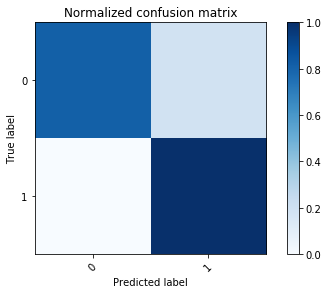

In [24]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

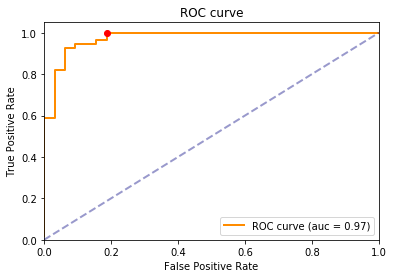

In [25]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), probability, pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), probability)

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

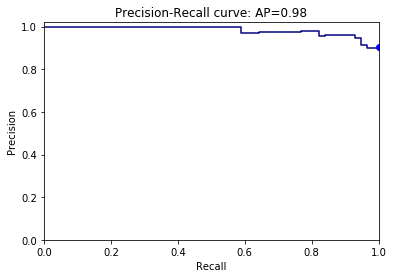

In [26]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test, probability,  pos_label=1)
ave_precision=average_precision_score(y_test, probability)

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot(cm_normalized[1,1], cm[1,1]/(cm[1,1]+cm[0,1]), 'ob')
plt.show()

In [27]:
# boto3.Session().client('sagemaker').delete_endpoint(EndpointName='xgboost-bikeRental-Optimized')